In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
import random
import tqdm
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import math
import logging
from functools import partial
from collections import OrderedDict
from sklearn.metrics import classification_report
from torchsummary import summary
from scipy import misc

In [2]:
!nvidia-smi
torch.cuda.is_available()

Fri Sep  3 11:08:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 48%   55C    P2   251W / 260W |  11008MiB / 11011MiB |     95%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [3]:
cd /home/is/zheng-ch/Transformer/resultvit

/home/is/zheng-ch/Transformer/resultvit


In [ ]:
cd /project/hikaku_db/data/sleep_SHHS/stages_sig/

In [692]:
#dat1 = np.load('/project/hikaku_db/data/sleep_SHHS/stages_sig/C3_spec_30_np/spec_c3_5007_5793_30.npy')
#dat2 = np.load('/project/hikaku_db/data/sleep_SHHS/stages_sig/C4_spec_30_np/spec_5007_5793_30.npy')
print(dat1.shape)
print(dat2.shape)

dat = np.concatenate((dat1.reshape(-1,1,32,30), dat2.reshape(-1,1,32,30)), axis=1)
print(dat.shape)

(2500, 32, 30)
(2500, 1, 32, 30)


In [697]:
dat1 = np.load('/project/hikaku_db/data/sleep_SHHS/spec_vit_c4.npy')
dat2 = np.load('/project/hikaku_db/data/sleep_SHHS/spec_vit_c3.npy')
print(dat1.shape)
print(dat2.shape)

dat = np.concatenate((dat1.reshape(-1,1,32,30), dat2.reshape(-1,1,32,30)), axis=1)
print(dat.shape)

(2500, 32, 30)
(2500, 32, 30)
(2500, 2, 32, 30)


In [701]:
index = np.load('/project/hikaku_db/data/sleep_SHHS/lable_2500.npy')
label = index.tolist()#list
print(len(label))

2500


In [668]:
index = pd.read_csv("/project/hikaku_db/data/sleep_SHHS/stages_sig/ann_delrecords_5class.csv", header=None)
index = index.astype(int)
print(index[0:790121].apply(pd.value_counts))
label = index[0:790121].values.tolist()#list
print(len(label))
#a=index[5007610:5794216].apply(pd.value_counts)
#print(a.sort_index())
#label=a.sort_index().values.tolist()
#label[1][1]

        0
2  329696
0  221935
4  109008
3  100831
1   28651
790121


In [702]:
label.index([0])
indexes = [i for i,x in enumerate(label) if x == [0]]
print(indexes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [703]:
def maka_patch_data(dat):
    dat=np.array(dat).reshape(-1,2,32,30)
    fixdata = dat[:,:,0:16,:]
    mean_p1 = np.mean(dat[:,:,16:20,:], axis = 2)
    mean_p2 = np.mean(dat[:,:,20:24,:], axis = 2)
    mean_p3 = np.mean(dat[:,:,24:28,:], axis = 2)
    mean_p4 = np.mean(dat[:,:,28:32,:], axis = 2)
    num_data = len(dat)
    ch = 2
    inputdat = np.concatenate((fixdata,mean_p1.reshape(num_data, ch, 1, 30),mean_p2.reshape(num_data, ch, 1, 30),mean_p3.reshape(num_data, ch, 1, 30),mean_p4.reshape(num_data, ch, 1, 30)),axis=2)
    return torch.tensor(inputdat)


class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data, label , make_patch=False,transform = None):
        self.transform = transform

        self.data = data
        self.label = label
        self.make_patch=make_patch

        self.datanum = len(data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        if not self.make_patch:
            out_data = torch.tensor(self.data[idx]).float()
            out_label = torch.tensor(self.label[idx])
        else:
            out_data = maka_patch_data(self.data[idx]).float()
            out_label = torch.tensor(self.label[idx])
        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [704]:
print(dat.shape)
# label = index[0:100].values.tolist()#list
print(len(label))
fixdata = dat[:,:,0:16,:]
mean_p1 = np.mean(dat[:,:,16:20,:], axis = 2)
mean_p2 = np.mean(dat[:,:,20:24,:], axis = 2)
mean_p3 = np.mean(dat[:,:,24:28,:], axis = 2)
mean_p4 = np.mean(dat[:,:,28:32,:], axis = 2)
num_data = len(dat)
ch = 2
inputdat = np.concatenate((fixdata,mean_p1.reshape(num_data, ch, 1, 30),mean_p2.reshape(num_data, ch, 1, 30),mean_p3.reshape(num_data, ch, 1, 30),mean_p4.reshape(num_data, ch, 1, 30)),axis=2)
print(inputdat.shape)

train, test, train_label, test_label = train_test_split(dat, np.array(label),test_size = 0.1,stratify = label,random_state = 0)
print('train data:',len(train))
print('test data:',len(test))

train_data_set = Mydatasets(data=train,label=train_label)
test_data_set = Mydatasets(data=test,label=test_label,make_patch=False)
test_data_set_patch = Mydatasets(data=test,label=test_label,make_patch=True)


train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=False)

(2500, 2, 32, 30)
2500
(2500, 2, 20, 30)
train data: 2250
test data: 250


In [705]:
##no train test split
print(dat.shape)
# label = index[0:100].values.tolist()#list
print(len(label))
fixdata = dat[:,:,0:16,:]
mean_p1 = np.mean(dat[:,:,16:20,:], axis = 2)
mean_p2 = np.mean(dat[:,:,20:24,:], axis = 2)
mean_p3 = np.mean(dat[:,:,24:28,:], axis = 2)
mean_p4 = np.mean(dat[:,:,28:32,:], axis = 2)
num_data = len(dat)
ch = 2
inputdat = np.concatenate((fixdata,mean_p1.reshape(num_data, ch, 1, 30),mean_p2.reshape(num_data, ch, 1, 30),mean_p3.reshape(num_data, ch, 1, 30),mean_p4.reshape(num_data, ch, 1, 30)),axis=2)
print(inputdat.shape)

test_data_set = Mydatasets(data=dat,label=np.array(label),make_patch=False)
test_data_set_patch = Mydatasets(data=dat,label=np.array(label),make_patch=True)


(2500, 2, 32, 30)
2500
(2500, 2, 20, 30)


In [706]:
##Transformer model, flatted the EEG channel, allows parallel computation the multi-band from multi-channel. 

class PreNorm(nn.Module): 
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout = 0.5):
        super().__init__()
        inner_dim = dim_head *  heads       ##32(4*8)   
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)   ##better to dim to dim*3

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out),attn
        

class Transformer(nn.Module):           ##Register the blocks into whole network
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.5):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            vdot,attention=attn(x)
            x = vdot + x
            x = ff(x) + x
        return x
    
    def get_attention(self,x):
        attention_list=[]
        for attn, ff in self.layers:
            vdot,attention=attn(x)
            attention_list.append(attention.cpu())
        return attention_list

class ViT(nn.Module):
    def __init__(self, *, image_size, time_size, fre_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels , dim_head, dropout = 0.5, emb_dropout = 0.):
        super().__init__()
        assert image_size == 30  ##Time dimensions must equal to 30s
        num_patches = 300       #30*5'
        patch_dim = time_size * fre_size    #1*4'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w c) (p1 p2)', p1 = fre_size, p2 = time_size),
            nn.Linear(patch_dim, dim),        ##4 to dim
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) ##Generate the pos value'
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))                ##Generate the class value'
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)
    
    def get_attention(self,img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        attention = self.transformer.get_attention(x)
        return attention



In [707]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

Transmodel = ViT(
    image_size = 30, 
    time_size = 1, 
    fre_size = 4, 
    num_classes = 5, 
    dim = 32, 
    depth = 8, 
    heads = 4, 
    mlp_dim = 128, 
    channels = 2,
    dim_head = 16
)

#summary(Transmodel,(2286886, 20, 30))


criterion = torch.nn.CrossEntropyLoss()
Transmodel .load_state_dict(torch.load('/project/hikaku_db/_koki-od/eeg_vit/PreTest_Trans_8lay_50drop_noW_eegspec_state6'))
#optimizer = torch.optim.AdamW(Transmodel.parameters(), lr=1e-3)

#Transmodel.load_state_dict(torch.load('PreTrained_t_Trans_8lay_50drop_mulchan_eegspec_stateTrain'))
#Transmodel.load_state_dict(torch.load('PreTest_Trans_8lay_50drop_noW_eegspec_state3'))




cuda:0


<All keys matched successfully>

In [708]:
#load ViTmodel of is(1*32)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

Transmodel_1s= ViT(
    image_size = 30, 
    time_size = 1,  ### 1 second
    fre_size = 32, ##### all bands
    num_classes = 5, 
    dim = 32, 
    depth = 8, 
    heads = 4, 
    mlp_dim = 128, 
    channels = 2,
    dim_head = 16
)

#summary(Transmodel,(2286886, 20, 30))


criterion = torch.nn.CrossEntropyLoss()
Transmodel_1s .load_state_dict(torch.load('/project/hikaku_db/_koki-od/eeg_vit/PreTest_Trans_8lay_nodrop_noW_eegspec_state6_1second'))
#optimizer = torch.optim.AdamW(Transmodel.parameters(), lr=1e-3)

cuda:0


<All keys matched successfully>

In [709]:
import cv2
def patch_attention(idx,dataset=test_data_set_patch):
    Transmodel.eval()
    data=dataset[idx][0]
    index = Transmodel(data.reshape(-1,2,20,30))
    att_mat = torch.stack(Transmodel.get_attention(data.reshape(-1,2,20,30))).squeeze(1)
    #print(att_mat.shape)
    att_mat = torch.mean(att_mat, dim=1)
    #print(att_mat.shape)
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    #print(aug_att_mat.shape)
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    for i, v in enumerate(joint_attentions[-1:]):
        # Attention from the output token to the input space.
        mask = v[0, 1:].detach().numpy()
        #print(mask.shape)
        img=np.squeeze(Rearrange('b (h w c) -> b c h w',h = 5, w = 30)(mask.reshape(-1,300)))
    return img,index

In [710]:
def sec_attention(idx,dataset=test_data_set):
    Transmodel_1s.eval()
    data=test_data_set[idx][0]
    index=Transmodel_1s(data.reshape(-1,2,32,30))
    att_mat = torch.stack(Transmodel_1s.get_attention(data.reshape(-1,2,32,30))).squeeze(1)
    #print(att_mat.shape)
    att_mat = torch.mean(att_mat, dim=1)
    #print(att_mat.shape)
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    #print(aug_att_mat.shape)
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    for i, v in enumerate(joint_attentions[-1:]):
        # Attention from the output token to the input space.
        mask = v[0, 1:].detach().numpy()
        #print(mask.shape)
        img=np.squeeze(Rearrange('b (h w c) -> b c h w',h = 1, w = 30)(mask.reshape(-1,60)))
    return img,index,test_data_set[idx][1].item()

In [711]:
test_data_set[0][0][0].shape

torch.Size([32, 30])

In [735]:
def show_all(idx):
    img_sec,index,label=sec_attention(idx)
    print(label)
    print(torch.argmax(index).item())
    img_patch,index=patch_attention(idx)
    print(torch.argmax(index).item())
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))
    ax1.set_title('Original_1ch')
    ax2.set_title('Original_2ch')
    original_img1= ax1.imshow(test_data_set[idx][0][0].numpy())
    fig.colorbar(original_img1, ax=ax1)
    original_img2 = ax2.imshow(test_data_set[idx][0][1].numpy())
    fig.colorbar(original_img2, ax=ax2)
    plt.show()
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))
    img_sec0=cv2.resize(img_sec[0].reshape(1,30),(30,20))
    img_sec1=cv2.resize(img_sec[1].reshape(1,30),(30,20))
    ax1.set_title('attention1s_1ch')
    ax2.set_title('attention1s_2ch')
    sec_img1 = ax1.imshow(img_sec0)
    fig.colorbar(sec_img1, ax=ax1)
    sec_img2 = ax2.imshow(img_sec1)
    fig.colorbar(sec_img2, ax=ax2)
    plt.savefig('/home/is/zheng-ch/Transformer/resultvit/N2sameF1attenvit_1s.pdf')
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))
    img_patch0=cv2.resize(img_patch[0].reshape(5,30),(30,20))
    img_patch1=cv2.resize(img_patch[1].reshape(5,30),(30,20))
    ax1.set_title('attention_patch_1ch')
    ax2.set_title('attention_patch_2ch')
    patch_img0 = ax1.imshow(img_patch0)
    fig.colorbar(patch_img0 , ax=ax1)
    #img_patch0.savefig("whole_figure.png")
    patch_img1 = ax2.imshow(img_patch1)
    fig.colorbar(patch_img1 , ax=ax2)
    #cv2.imwrite('ViTattentionc3.pdf',patch_img1)
    plt.savefig('/home/is/zheng-ch/Transformer/resultvit/N2sameF1attenvit_patch.pdf')
    

2
2
2


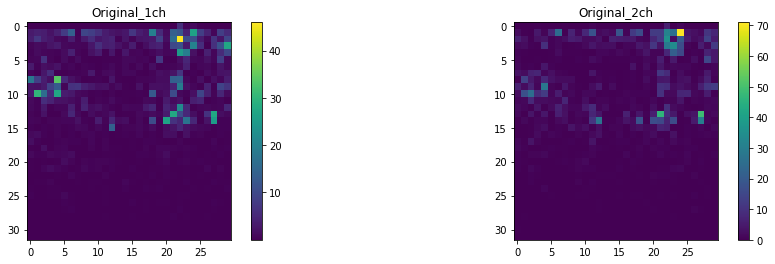

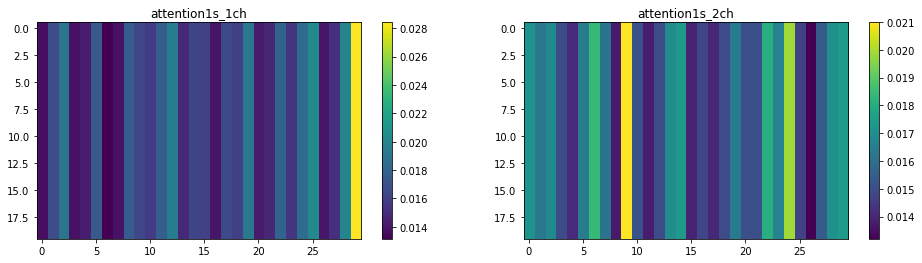

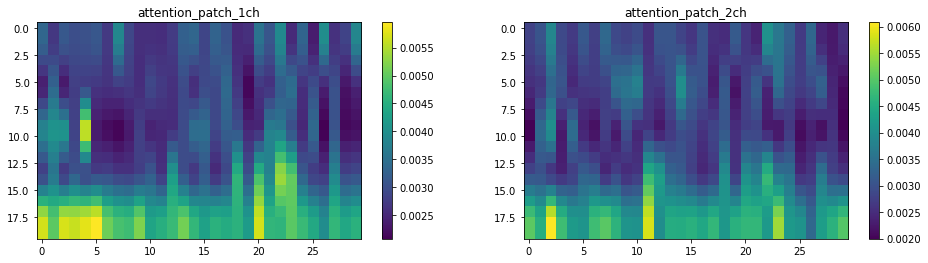

In [736]:
ls=1033
show_all(ls)

1


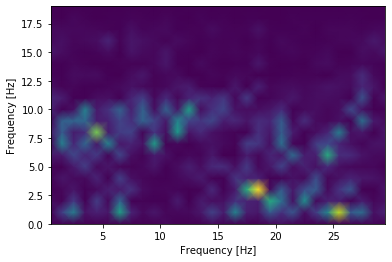

In [733]:
ls=551
t = np.arange(0.5, 30.5,1)
f= np.arange(0,20,1)
plt.pcolormesh(t, f, test_data_set_patch[ls][0][0][0].numpy(), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Frequency [Hz]')
plt.plot()
plt.savefig('/home/is/zheng-ch/Transformer/resultvit/N1sameF1c4.pdf')
print(test_data_set_patch[ls][1].item())

###### ls=133
t = np.arange(0.5, 30.5,1)
f= np.arange(0,20,1)
plt.pcolormesh(t, f, test_data_set_patch[ls][0][0][0].numpy(), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Frequency [Hz]')
plt.plot()
plt.savefig('/home/is/zheng-ch/Transformer/resultvit/N3orgc4.pdf')
print(test_data_set_patch[ls][1].item())

In [736]:
plt.savefig('/home/is/zheng-ch/Transformer/resultvit/wakeorgc4.pdf')

<Figure size 432x288 with 0 Axes>

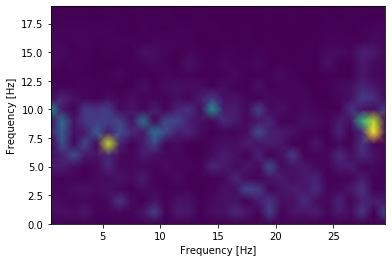

In [734]:
t = np.arange(0.5, 30.5,1)
f= np.arange(0,20,1)
plt.pcolormesh(t, f, test_data_set_patch[ls][0][0][1].numpy(), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Frequency [Hz]')
plt.plot()
plt.savefig('N1sameF1c3.pdf')

In [ ]:
import cv2
def patch_attention(idx,dataset=test_data_set):
    Transmodel.eval()
    data=test_data_set[idx][0]
    att_mat = torch.stack(Transmodel.get_attention(data.reshape(-1,2,20,30))).squeeze(1)
    #print(att_mat.shape)
    att_mat = torch.mean(att_mat, dim=1)
    #print(att_mat.shape)
    residual_att = torch.eye(att_mat.size(1))
    
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    #print(aug_att_mat.shape)
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    for i, v in enumerate(joint_attentions[-1:]):
        # Attention from the output token to the input space.
        mask = v[0, 1:].detach().numpy()
        #print(mask.shape)
        img=np.squeeze(Rearrange('b (h w c) -> b c h w',h = 5, w = 30)(mask.reshape(-1,300)))
    return img

In [724]:
#define  a code to show 
def show_all_gram(idx, class_index=None,data=test_data_set,data_patch=test_data_set_patch):
    answer_dict={0 : 'Wake',1 : 'N1',2 : 'N2',3 : 'N3', 4 : 'REM'}
    temp,index=generate_visualization_1s_gram(data[idx][0].reshape(-1,2,32,30).cuda())
    temp_patch,index_patch=generate_visualization_gram(data_patch[idx][0].reshape(-1,2,20,30).cuda())
    print('truth:{}'.format(answer_dict[data_patch[idx][1].numpy()[0]]))
    print('model_patch predict:{}'.format(answer_dict[index_patch[0]]))
    print('model_1s predict:{}'.format(answer_dict[index[0]]))
    #print(temp.shape)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))
    ax1.set_title('Original 1ch')
    ax2.set_title('Original 2ch')
    original1 = ax1.imshow(data[idx][0].squeeze()[0].numpy())
    fig.colorbar(original1, ax=ax1)
    original2 = ax2.imshow(data[idx][0].squeeze()[1].numpy())
    fig.colorbar(original2, ax=ax2)
    plt.show()
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))
    ax1.set_title('Attention_patch ch1')
    ax2.set_title('Attention_patch ch2')
    patch_attention1 = ax1.imshow(temp_patch[0])
    fig.colorbar(patch_attention1, ax=ax1)
    patch_attention2 = ax2.imshow(temp_patch[1])
    fig.colorbar(patch_attention2, ax=ax2)    
    #plt.savefig('/home/is/zheng-ch/Transformer/resultvit/REM_gramvit_patch.pdf')
    plt.show()
    
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))
    ax1.set_title('attention 1s ch1')
    ax2.set_title('attention 1s ch2')
    sec_attention1 = ax1.imshow(temp[0])
    fig.colorbar(sec_attention1, ax=ax1)
    sec_attention2 = ax2.imshow(temp[1])
    fig.colorbar(sec_attention2, ax=ax2)
    #plt.savefig('/home/is/zheng-ch/Transformer/resultvit/REM_gramvit_1s.pdf')
    plt.show()
    

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


truth:Wake
model_patch predict:Wake
model_1s predict:Wake


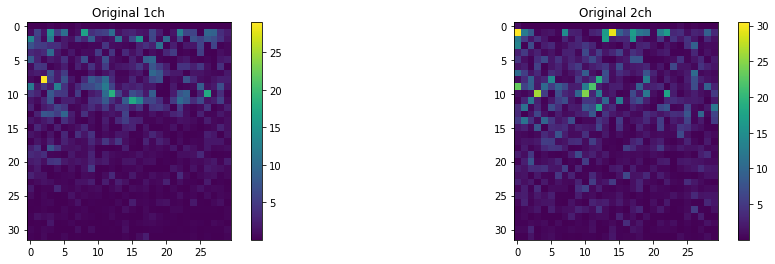

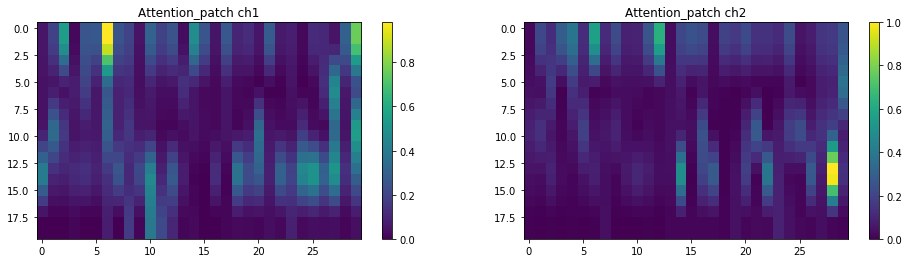

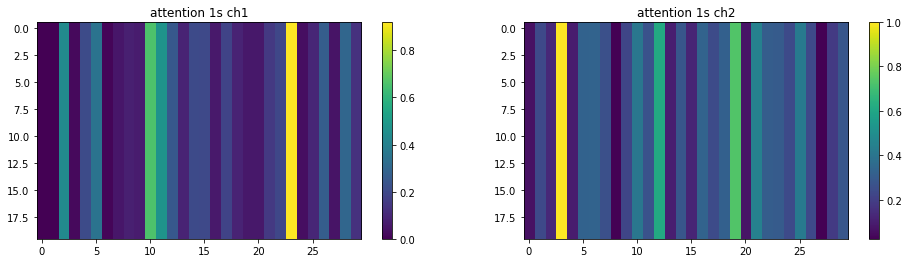

In [725]:
ls = 11
show_all_gram(ls)

In [ ]:
patch_attention(0)

In [147]:
print(test_data_set[100][0].numpy()[0].shape)

(32, 30)


In [19]:
##Transformer model, flatted the EEG channel, allows parallel computation the multi-band from multi-channel. 
# change some parts to implement  features(Transformer Interpretability Beyond Attention Visualization) :odani

class PreNorm(nn.Module): 
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout = 0.5):
        super().__init__()
        inner_dim = dim_head *  heads       ##32(4*8)   
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)   ##better to dim to dim*3

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
        self.attn_gradients = None
        self.attention_map = None

    def save_attn_gradients(self, attn_gradients):
        self.attn_gradients = attn_gradients

    def get_attn_gradients(self):
        return self.attn_gradients

    def save_attention_map(self, attention_map):
        self.attention_map = attention_map

    def get_attention_map(self):
        return self.attention_map
        

    def forward(self, x,register_hook=False):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)
        self.save_attention_map(attn)
        if register_hook:
            attn.register_hook(self.save_attn_gradients)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)
        

class Transformer(nn.Module):           ##Register the blocks into whole network
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.5):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x,register_hook=False):
        for attn, ff in self.layers:
            vdot=attn(x,register_hook=register_hook)
            x = vdot + x
            x = ff(x) + x
        return x
    

class ViT_Gram(nn.Module):
    def __init__(self, *, image_size, time_size, fre_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels , dim_head, dropout = 0.5, emb_dropout = 0.):
        super().__init__()
        assert image_size == 30  ##Time dimensions must equal to 30s
        num_patches = 300       #30*5'
        patch_dim = time_size * fre_size    #1*4'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w c) (p1 p2)', p1 = fre_size, p2 = time_size),
            nn.Linear(patch_dim, dim),        ##4 to dim
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) ##Generate the pos value'
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))                ##Generate the class value'
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img,register_hook=False):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x,register_hook=register_hook)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)
    




In [20]:
#load ViTmodel of patch(1*4)


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

Transmodel_Gram = ViT_Gram(
    image_size = 30, 
    time_size = 1, 
    fre_size = 4, 
    num_classes = 5, 
    dim = 32, 
    depth = 8, 
    heads = 4, 
    mlp_dim = 128, 
    channels = 2,
    dim_head = 16
)

#summary(Transmodel,(2286886, 20, 30))


criterion = torch.nn.CrossEntropyLoss()
#load_parameters
Transmodel_Gram.load_state_dict(torch.load('/project/hikaku_db/_koki-od/eeg_vit/PreTest_Trans_8lay_50drop_noW_eegspec_state6'))
#optimizer = torch.optim.AdamW(Transmodel.parameters(), lr=1e-3)

#Transmodel.load_state_dict(torch.load('PreTrained_t_Trans_8lay_50drop_mulchan_eegspec_stateTrain'))
#Transmodel.load_state_dict(torch.load('PreTest_Trans_8lay_50drop_noW_eegspec_state3'))



#load ViTmodel of is(1*32)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

Transmodel_Gram_1s= ViT_Gram(
    image_size = 30, 
    time_size = 1,  ### 1 second
    fre_size = 32, ##### all bands
    num_classes = 5, 
    dim = 32, 
    depth = 8, 
    heads = 4, 
    mlp_dim = 128, 
    channels = 2,
    dim_head = 16
).to(DEVICE)

#summary(Transmodel,(2286886, 20, 30))


criterion = torch.nn.CrossEntropyLoss()
Transmodel_Gram_1s.load_state_dict(torch.load('/project/hikaku_db/_koki-od/eeg_vit/PreTest_Trans_8lay_nodrop_noW_eegspec_state6_1second'))
#optimizer = torch.optim.AdamW(Transmodel.parameters(), lr=1e-3)






cuda:0
cuda:0


<All keys matched successfully>

In [721]:
#code for features(Transformer Interpretability Beyond Attention Visualization) :odani
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

# rule 6 from paper
def apply_self_attention_rules(R_ss, cam_ss):
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition

def generate_relevance(model, input, index=None):
    output = model(input, register_hook=True)
    if index == None:
        index = np.argmax(output.cpu().data.numpy(), axis=-1)

    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * output)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    num_tokens = model.transformer.layers[0][0].fn.get_attention_map().shape[-1]
    R = torch.eye(num_tokens, num_tokens).cuda()
    for attn,ff in model.transformer.layers:
        grad = attn.fn.get_attn_gradients()
        cam =  attn.fn.get_attention_map()
        cam = avg_heads(cam, grad)
        R += apply_self_attention_rules(R.cuda(), cam.cuda())
        return R[0, 1:],index

In [722]:
#grad_attention_visualization for patch ViT
def generate_visualization_gram(original_image, class_index=None):
    transformer_attribution,index = generate_relevance(Transmodel_Gram.cuda().eval() ,original_image.cuda(), index=class_index)
    transformer_attribution =Rearrange('b (h w c) -> b c h w',h = 5, w = 30)(transformer_attribution.reshape(-1,300))
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=(4,1), mode='bilinear')
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    return np.squeeze(transformer_attribution.data.cpu().numpy()),index
    #transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    #transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    
def show_attention(idx, class_index=None,data=test_data_set_patch):
    answer_dict={0 : 'Wake',1 : 'N1',2 : 'N2',3 : 'N3', 4 : 'REM'}
    temp,index=generate_visualization_gram(data[idx][0].reshape(-1,2,20,30).cuda())
    print('truth:{}'.format(answer_dict[data[idx][1].numpy()[0]]))
    print('model predict:{}'.format(answer_dict[index[0]]))
    #print(temp.shape)
    #print(data[idx][0][0].shape)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original 1ch')
    ax2.set_title('Original 2ch')
    _ = ax1.imshow(data[idx][0].squeeze()[0].numpy())
    _ = ax2.imshow(data[idx][0].squeeze()[1].numpy())
    plt.show()
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Attention_1s 1ch')
    ax2.set_title('Attention_1s 2ch')
    _ = ax1.imshow(temp[0])
    _ = ax2.imshow(temp[1])
    plt.show()

In [723]:
#grad_attention_visualization for 1s
def generate_visualization_1s_gram(original_image, class_index=None):
    transformer_attribution,index = generate_relevance(Transmodel_Gram_1s.cuda().eval() ,original_image.cuda(), index=class_index)
    transformer_attribution =Rearrange('b (h w c) -> b c h w',h = 1, w = 30)(transformer_attribution.reshape(-1,60))
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=(20,1), mode='bilinear')
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    return np.squeeze(transformer_attribution.data.cpu().numpy()),index
    #transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    #transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')

def show_attention_1s(idx, class_index=None,data=test_data_set):
    answer_dict={0 : 'Wake',1 : 'N1',2 : 'N2',3 : 'N3', 4 : 'REM'}
    temp,index=generate_visualization_1s_gram(data[idx][0].reshape(-1,2,32,30).cuda())
    print('truth:{}'.format(answer_dict[data[idx][1].numpy()[0]]))
    print('model predict:{}'.format(answer_dict[index[0]]))
    #print(temp.shape)    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('attention 1s ch1')
    ax2.set_title('attention 1s ch2')
    _ = ax1.imshow(temp[0])
    _ = ax2.imshow(temp[1])
    plt.show()

In [24]:
#define  a code to show 
def show_all_gram(idx, class_index=None,data=test_data_set,data_patch=test_data_set_patch):
    answer_dict={0 : 'Wake',1 : 'N1',2 : 'N2',3 : 'N3', 4 : 'REM'}
    temp,index=generate_visualization_1s_gram(data[idx][0].reshape(-1,2,32,30).cuda())
    temp_patch,index_patch=generate_visualization_gram(data_patch[idx][0].reshape(-1,2,20,30).cuda())
    print('truth:{}'.format(answer_dict[data_patch[idx][1].numpy()[0]]))
    print('model_patch predict:{}'.format(answer_dict[index_patch[0]]))
    print('model_1s predict:{}'.format(answer_dict[index[0]]))
    #print(temp.shape)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))
    ax1.set_title('Original 1ch')
    ax2.set_title('Original 2ch')
    original1 = ax1.imshow(data[idx][0].squeeze()[0].numpy())
    fig.colorbar(original1, ax=ax1)
    original2 = ax2.imshow(data[idx][0].squeeze()[1].numpy())
    fig.colorbar(original2, ax=ax2)
    plt.show()
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))
    ax1.set_title('Attention_patch ch1')
    ax2.set_title('Attention_patch ch2')
    patch_attention1 = ax1.imshow(temp_patch[0])
    fig.colorbar(patch_attention1, ax=ax1)
    patch_attention2 = ax2.imshow(temp_patch[1])
    fig.colorbar(patch_attention2, ax=ax2)    
    plt.show()
    plt.savefig('/home/is/zheng-ch/Transformer/resultvit/wake_gramvit_patch.pdf')
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4))
    ax1.set_title('attention 1s ch1')
    ax2.set_title('attention 1s ch2')
    sec_attention1 = ax1.imshow(temp[0])
    fig.colorbar(sec_attention1, ax=ax1)
    sec_attention2 = ax2.imshow(temp[1])
    fig.colorbar(sec_attention2, ax=ax2)
    plt.show()
    plt.savefig('/home/is/zheng-ch/Transformer/resultvit/wake_gramvit_1s.pdf')
             

truth:Wake
model_patch predict:Wake
model_1s predict:Wake


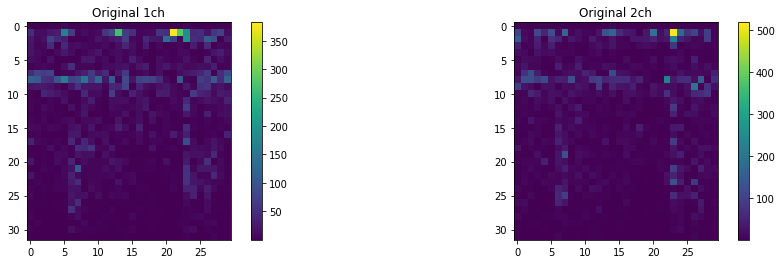

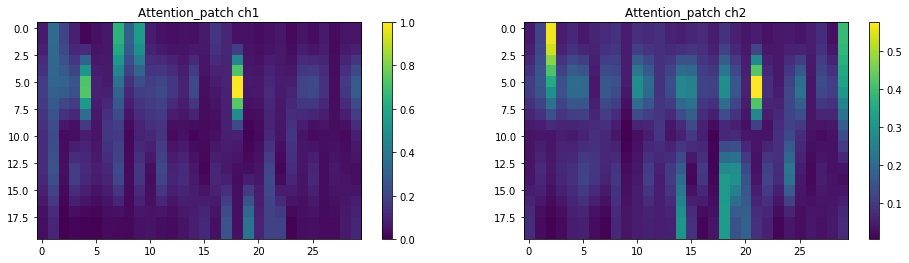

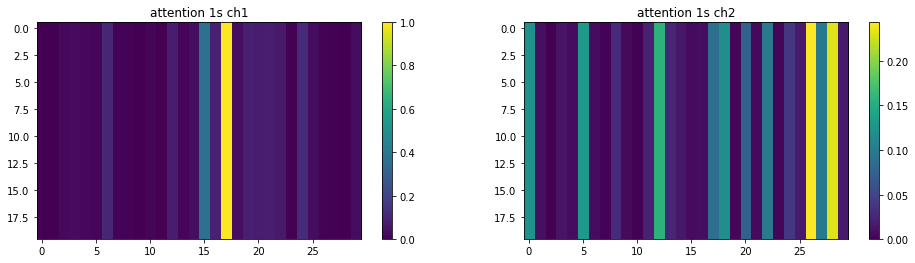

In [273]:
show_all_gram(374)